In [1]:
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import StratifiedGroupKFold
from pandarallel import pandarallel
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
import massspecgym.utils as utils

In [2]:
df = pd.read_csv('../data/data/MassSpecGym.tsv', sep='\t')
df.head()

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_50248/2111678167.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/data/MassSpecGym.tsv', sep='\t')


,mzs,intensities,smiles,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,collision_energy,identifier
0,"91.0542,125.0233,154.0499,155.0577,185.0961,20...","0.24524524524524524,1.0,0.08008008008008008,0....",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"30.0 (normalized=False, ramped=False)",MassSpecGymID0000001
1,"91.0542,125.0233,155.0577,185.0961,229.0859,24...","0.0990990990990991,0.28128128128128127,0.04004...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"20.0 (normalized=False, ramped=False)",MassSpecGymID0000002
2,"69.0343,91.0542,125.0233,127.039,153.0699,154....","0.03403403403403404,0.31431431431431434,1.0,0....",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"40.0 (normalized=False, ramped=False)",MassSpecGymID0000003
3,"69.0343,91.0542,110.06,111.0441,112.0393,120.0...","0.17917917917917917,0.47347347347347346,0.0380...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"55.0 (normalized=False, ramped=False)",MassSpecGymID0000004
4,"91.0542,125.0233,185.0961,229.0859,246.1125,28...","0.07807807807807808,0.1841841841841842,0.03503...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ-AWEZNQCLSA-N,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"10.0 (normalized=False, ramped=False)",MassSpecGymID0000005


### Prepare SMILES and pre-computed MCES distances

In [3]:
f = h5py.File('../data/all_smiles_standardized_mces/all_smiles_mces.hdf5', 'r')
print(list(f.keys()))
dists = squareform(f['mces'])
dists_smiles = f['mces_smiles_order'][:].astype(str).tolist()
dists.shape, len(dists_smiles)

['mces', 'mces_smiles_order']


((34731, 34731), 34731)

In [4]:
for s in df['smiles'].unique():
    assert s in dists_smiles

In [5]:
unique_smiles = df['smiles'].unique()
smiles_mask = np.array([s in unique_smiles for s in dists_smiles])
print(smiles_mask.shape[0], smiles_mask.sum(), len(unique_smiles))

dists = dists[smiles_mask, :][:, smiles_mask]
dists_smiles = np.array(dists_smiles)[smiles_mask]

from scipy.linalg import issymmetric
print(issymmetric(dists))

len(dists_smiles), dists.shape

34731 33597 33597
True


(33597, (33597, 33597))

### Perform agglomerative clustering using MCES distances

In [6]:
clustering = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    distance_threshold=10,
    n_clusters=None
).fit(dists)
clusters = clustering.labels_
pd.Series(clusters).value_counts()

86      21807
236       128
1912      101
207        94
480        91
        ...  
5323        1
5324        1
5325        1
5326        1
647         1
Name: count, Length: 7702, dtype: int64

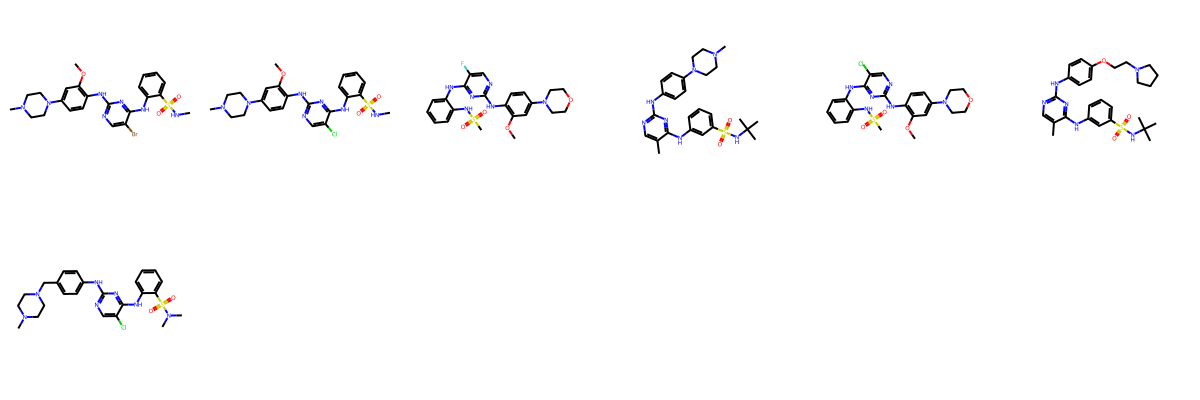

In [7]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in dists_smiles[np.where(clusters == 80)[0]]], molsPerRow=6, subImgSize=(200, 200))

### Define train-validation-test split

Compute metadata stratification groups

In [8]:
smiles_to_cluster = dict(zip(dists_smiles, clusters))
df['cluster'] = df['smiles'].map(smiles_to_cluster)

top_k_ces = df['collision_energy'].value_counts().index[:5]
smiles_vc = df['smiles'].value_counts()

def simple_ce(ce):
    if pd.isnull(ce):
        return 'none'
    if ce in top_k_ces:
        return ce
    return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c < 3:
        return '(0, 3)'
    elif c <= 5:
        return '(3, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def stratification_group(row):
    return str(row['adduct']) + \
        str(row['instrument_type']) + \
        str(simple_ce(row['collision_energy'])) + \
        str(simple_smiles_count(row['smiles']))
df['stratification_group'] = df.apply(stratification_group, axis=1)
df['stratification_group'].value_counts()

stratification_group
[M+H]+ITFTnone(5, 100]                                        73652
[M+H]+ITFTnone(100, inf)                                      57974
[M+Na]+ITFTnone(5, 100]                                       55004
[M+Na]+ITFTnone(100, inf)                                     48371
[M+H]+QTOFother(5, 100]                                       16550
                                                              ...  
[M+H]+nan10.0 (normalized=False, ramped=False)(0, 3)              1
[M+H]+nan30.0 (normalized=False, ramped=False)(0, 3)              1
[M+Na]+QTOF30.0 (normalized=False, ramped=False)(3, 5]            1
[M+Na]+Orbitrap60.0 (normalized=False, ramped=False)(0, 3)        1
[M+Na]+Orbitrapother(0, 3)                                        1
Name: count, Length: 166, dtype: int64

In [94]:
# def smiles_stratification_group(row):
#     n_spectra = row['n_spectra']
#     if n_spectra < 3:
#         return '(0, 3]'
#     elif n_spectra <= 5:
#         return '(3, 5]'
#     elif n_spectra > 100:
#         return '(100, inf)'
#     return '(5, 100]'

# df_smiles = df.groupby('smiles').agg({
#     'identifier': 'count',
#     'cluster': 'first'
# }).rename(columns={
#     'identifier': 'n_spectra'
# }).reset_index()

# df_smiles['stratification_group'] = df_smiles.apply(smiles_stratification_group, axis=1)
# df_smiles

# X = df_smiles['smiles'].values
# y = df_smiles['stratification_group'].values
# groups = df_smiles['cluster'].values
# sgkf = StratifiedGroupKFold(n_splits=3)
# sgkf_split = sgkf.split(X, y, groups)
# folds = []
# for i, (train_index, test_index) in enumerate(sgkf_split):
#     print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
#     folds.append(X[test_index])

Split with `StratifiedGroupKFold`

In [9]:
X = df['identifier'].values
y = df['stratification_group'].values
groups = df['cluster'].values
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)
folds = []
for i, (train_index, test_index) in enumerate(sgkf_split):
    print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
    folds.append(X[test_index])

/Users/roman/miniconda/envs/massspecgym/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


307981 (74.38 %)
52944 (12.79 %)
53124 (12.83 %)


In [10]:
folds_map = {}
for i, fold in enumerate(folds):
    for identifier in fold:
        folds_map[identifier] = ['train', 'val', 'test'][i]
df['fold'] = df['identifier'].map(folds_map)

def fold_composition(df_q, percentage=True):
    # Compute unique counts
    unique_counts = df_q.groupby(['fold']).agg({'smiles': 'nunique', 'identifier': 'nunique', 'cluster': 'nunique'})
    if not percentage:
        return unique_counts
    total_counts = df_q.agg({'smiles': 'nunique', 'identifier': 'nunique', 'cluster': 'nunique'})
    percentage_counts = (unique_counts / total_counts) * 100
    percentage_counts = percentage_counts.round(2)
    return percentage_counts
for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df.dropna(), percentage=percentage))

Full dataset (percentage=False)


,smiles,identifier,cluster
fold,,,
test,5866,53124,3827
train,21864,307981,58
val,5867,52944,3817


All metadata available (percentage=False)


,smiles,identifier,cluster
fold,,,
test,4255,18768,3252
train,10757,104014,58
val,4235,18611,3234


Full dataset (percentage=True)


,smiles,identifier,cluster
fold,,,
test,17.46,12.83,49.69
train,65.08,74.38,0.75
val,17.46,12.79,49.56


All metadata available (percentage=True)


,smiles,identifier,cluster
fold,,,
test,22.11,13.27,49.69
train,55.89,73.56,0.89
val,22.00,13.16,49.42


In [11]:
df_split = df.copy()
for f in ['val', 'test']:
    df_fold = df[df['fold'] == f].copy()
    rand_fold_clusters = df_fold['cluster'].drop_duplicates().sample(n=1500, random_state=42).values
    df_split.loc[df_split['cluster'].isin(rand_fold_clusters), 'fold'] = 'train'

for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df_split, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df_split.dropna(), percentage=percentage))

Full dataset (percentage=False)


,smiles,identifier,cluster
fold,,,
test,3316,25146,2327
train,26777,361307,3058
val,3504,27596,2317


All metadata available (percentage=False)


,smiles,identifier,cluster
fold,,,
test,2516,10613,1980
train,14173,119585,2596
val,2558,11195,1968


Full dataset (percentage=True)


,smiles,identifier,cluster
fold,,,
test,9.87,6.07,30.21
train,79.70,87.26,39.70
val,10.43,6.66,30.08


All metadata available (percentage=True)


,smiles,identifier,cluster
fold,,,
test,13.07,7.51,30.26
train,73.64,84.58,39.67
val,13.29,7.92,30.07


------------------------------ Full dataset ------------------------------


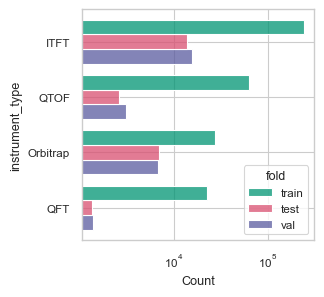

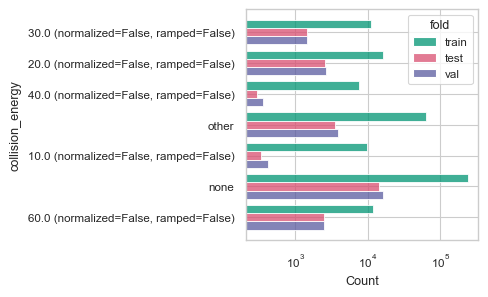

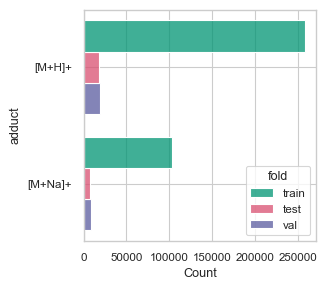

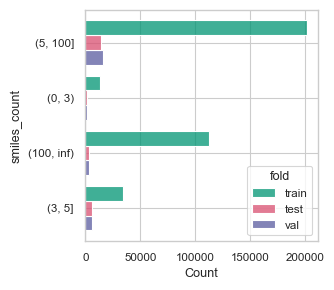

------------------------------ All metadata available ------------------------------


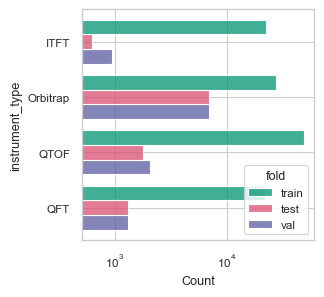

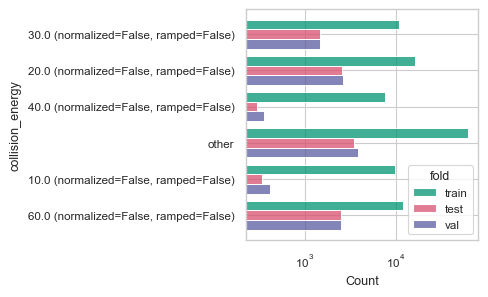

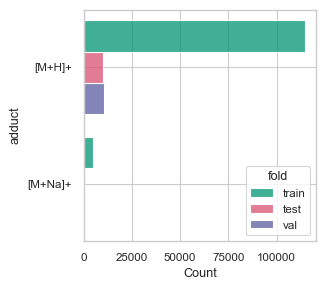

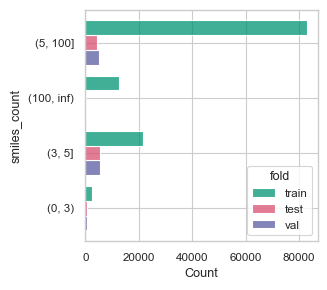

In [12]:
utils.init_plotting(figsize=(3, 3))

for df_name, df_plot in [('Full dataset', df_split.copy()), ('All metadata available', df_split.copy().dropna())]:
    print('-' * 30, df_name, '-' * 30)
    df_plot['instrument_type'] = df_plot['instrument_type'].str.replace('Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'Q Exactive')
    df_plot['collision_energy'] = df_plot['collision_energy'].apply(simple_ce)
    df_plot['smiles_count'] = df_plot['smiles'].apply(simple_smiles_count)

    sns.histplot(y='instrument_type', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    plt.xscale('log')
    plt.show()

    sns.histplot(y='collision_energy', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    plt.xscale('log')
    plt.show()

    sns.histplot(y='adduct', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    # plt.xscale('log')
    plt.show()

    sns.histplot(y='smiles_count', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    plt.show()

In [31]:
fps = {}
for fold in ['train', 'val', 'test']:
    df_fold = df_split[df_split['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: utils.morgan_fp(Chem.MolFromSmiles(s), to_np=False))
def max_train_tanimoto(test_fp, train_fps=fps['train']):
    return max([DataStructs.FingerprintSimilarity(test_fp, train_fp) for train_fp in train_fps])

100%|██████████| 3316/3316 [00:00<00:00, 4962.28it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


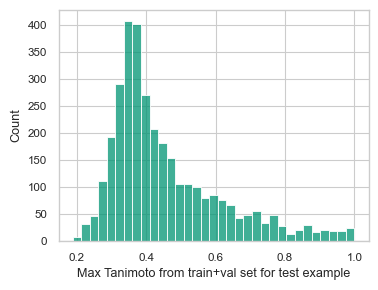

In [32]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['test'].parallel_apply(lambda f: max_train_tanimoto(f, pd.concat([fps['train'], fps['val']])))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train+val set for test example')
plt.show()

In [33]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['val'].parallel_apply(lambda f: max_train_tanimoto(f, fps['train']))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train set for validation example')
plt.show()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [29]:
df = df_split.drop(columns=['cluster', 'stratification_group'])
df['simulation_challenge'] = (~df.isna().sum(axis=1)) & (df['adduct'] == '[M+H]+')
df.to_csv('../data/data/MassSpecGym.tsv', sep='\t', index=False)

In [30]:
df['fold'].value_counts()

fold
train    307981
test      53124
val       52944
Name: count, dtype: int64